## Sentiment Analysis



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
import pandas as pd
import numpy as np

In [3]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [5]:
from sklearn.model_selection import train_test_split


In [6]:
max_words = 2000
max_len = 20
num_classes = 1

# Training
epochs = 5
batch_size = 512
print_batch_n = 100

In [7]:
df_train = pd.read_csv("text/train.csv")
df_val = pd.read_csv("text/test.csv")

In [8]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


0 - positive<br>
1 - negative

In [9]:
df_train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [10]:
df_val.tail()

,id,tweet
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid ð #hairflip #neverre...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."
17196,49159,"my song ""so glad"" free download! #shoegaze ..."


In [11]:
# test is without labels, so we'll split train to train and validation dataframes on label (label 1 is less than 10%)
X_train, X_test = train_test_split(df_train,test_size=0.3, stratify=df_train[['label']])

In [12]:
X_test['label'].value_counts()

0    8916
1     673
Name: label, dtype: int64

In [13]:
X_train['label'].value_counts()

0    20804
1     1569
Name: label, dtype: int64

### Предобработка

In [14]:
sw = set(get_stop_words("ru"))
# sw

In [15]:
puncts = set(punctuation)
puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [16]:
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if (word not in sw) & (word.isalnum())]
    # exclude all except letters and numbers
   
    return " ".join(txt)

In [17]:
X_train['tweet'].iloc[:1].values

array(['i am inventive. #i_am #positive #affirmation     '], dtype=object)

In [18]:
X_train['tweet'].iloc[:1].apply(preprocess_text).values

array(['i am inventive iam positive affirmation'], dtype=object)

In [19]:
from tqdm import tqdm 
tqdm.pandas()

X_train['tweet'] = X_train['tweet'].progress_apply(preprocess_text)
X_test['tweet'] = X_test['tweet'].progress_apply(preprocess_text)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9589/9589 [00:03<00:00, 2654.43it/s]


In [20]:
train_corpus = " ".join(X_train['tweet'])
train_corpus = train_corpus.lower()

In [21]:
tokens = word_tokenize(train_corpus)


In [22]:
tokens[:20]

['i',
 'am',
 'inventive',
 'iam',
 'positive',
 'affirmation',
 'i',
 'am',
 'thankful',
 'for',
 'holiday',
 'sales',
 'thankful',
 'positive',
 'user',
 'we',
 'welcome',
 'user',
 'to',
 'southern']

Cоберём в корпус N наиболее частых токенов

In [23]:
dist = FreqDist(tokens)
tokens_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_top)

1999

In [24]:
tokens_top[:10]

['user', 'the', 'to', 'a', 'i', 'you', 'and', 'in', 'for', 'of']

In [25]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_top, 1)).items()}
vocabulary

{'user': 1,
 'the': 2,
 'to': 3,
 'a': 4,
 'i': 5,
 'you': 6,
 'and': 7,
 'in': 8,
 'for': 9,
 'of': 10,
 'is': 11,
 'my': 12,
 'on': 13,
 'this': 14,
 'love': 15,
 'with': 16,
 'it': 17,
 'be': 18,
 'day': 19,
 'so': 20,
 'all': 21,
 'that': 22,
 'are': 23,
 'me': 24,
 'your': 25,
 'happy': 26,
 'at': 27,
 'have': 28,
 'amp': 29,
 'just': 30,
 'not': 31,
 'its': 32,
 'will': 33,
 'we': 34,
 'when': 35,
 'do': 36,
 'im': 37,
 'am': 38,
 'time': 39,
 'u': 40,
 'life': 41,
 'from': 42,
 'but': 43,
 'what': 44,
 'new': 45,
 'like': 46,
 'up': 47,
 'today': 48,
 'now': 49,
 'out': 50,
 'as': 51,
 'get': 52,
 'positive': 53,
 'was': 54,
 'our': 55,
 'about': 56,
 'thankful': 57,
 'bihday': 58,
 'how': 59,
 'people': 60,
 'by': 61,
 'good': 62,
 'cant': 63,
 'can': 64,
 'no': 65,
 'one': 66,
 'see': 67,
 'fathers': 68,
 'more': 69,
 'they': 70,
 'smile': 71,
 'go': 72,
 'dont': 73,
 'if': 74,
 'want': 75,
 'who': 76,
 'take': 77,
 'work': 78,
 'got': 79,
 'has': 80,
 'healthy': 81,
 'weekend

In [26]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [27]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in X_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in X_test["tweet"]])

CPU times: total: 4.14 s
Wall time: 4.14 s


In [28]:
x_train.shape

(22373, 20)

In [29]:
X_train['tweet'].iloc[0]

'i am inventive iam positive affirmation'

In [30]:
x_train[0]

array([  5,  38, 171,  53, 147,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])

In [31]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output

In [32]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [33]:
train_dataset = DataWrapper(x_train, X_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, X_test['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [34]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 20])
torch.Size([512])
tensor(0)


In [35]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [36]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 346497


In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [38]:
#model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
 #       inputs, labels = data[0].to(device), data[1].to(device)
        inputs, labels = data[0], data[1]
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1] #.to(device)
        test_outputs = model(data[0]) #.to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

Epoch [1/5]. Step [44/44]. Loss: 0.188. Acc: 0.930. Test loss: 0.097. Test acc: 0.930
Epoch [2/5]. Step [44/44]. Loss: 0.138. Acc: 0.930. Test loss: 0.035. Test acc: 0.943
Epoch [3/5]. Step [44/44]. Loss: 0.110. Acc: 0.957. Test loss: 0.033. Test acc: 0.948
Epoch [4/5]. Step [44/44]. Loss: 0.070. Acc: 0.972. Test loss: 0.007. Test acc: 0.946
Epoch [5/5]. Step [44/44]. Loss: 0.068. Acc: 0.983. Test loss: 0.001. Test acc: 0.941
Training is finished!


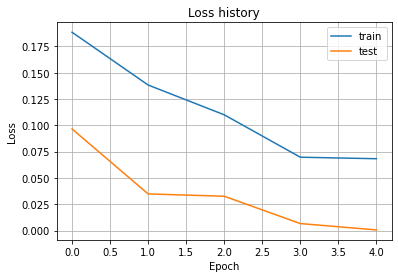

In [39]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();